In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils.data_utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History

In [ ]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [ ]:
vgg16 = VGG16(weights='imagenet')

In [ ]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

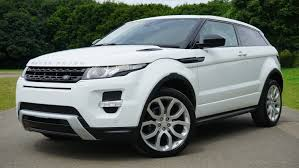

In [ ]:
Image('car.jpeg')

In [ ]:
def get_car_categories():
    d = defaultdict(float)
    img_list1 = os.listdir('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/damaged')
    
    for i, img_path in enumerate(img_list1):
        img = prepare_image_224('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/damaged/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list1),'complete')

    img_list2 = os.listdir('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/not_damaged')
 
    for i, img_path in enumerate(img_list2):
        img = prepare_image_224('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/not_damaged/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list2),'complete')
    return Counter(d)

In [ ]:
categ_count = get_car_categories()

1/1 [==============================] - 0s 400ms/step
0 / 460 complete
1/1 [==============================] - 0s 394ms/step
50 / 460 complete
1/1 [==============================] - 0s 402ms/step
100 / 460 complete
1/1 [==============================] - 0s 398ms/step
150 / 460 complete
1/1 [==============================] - 0s 393ms/step
200 / 460 complete
1/1 [==============================] - 0s 391ms/step
250 / 460 complete
1/1 [==============================] - 0s 398ms/step
300 / 460 complete
1/1 [==============================] - 0s 398ms/step
350 / 460 complete
1/1 [==============================] - 0s 403ms/step
400 / 460 complete
1/1 [==============================] - 0s 392ms/step
450 / 460 complete
1/1 [==============================] - 0s 396ms/step
0 / 460 complete
1/1 [==============================] - 0s 399ms/step
50 / 460 complete
1/1 [==============================] - 1s 658ms/step
100 / 460 complete
1/1 [==============================] - 0s 399ms/step
150 / 460 complet

In [ ]:
with open('vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [ ]:
with open('vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

In [ ]:
categ_list = [k for k, v in categ_count.most_common()[:50]]

In [ ]:
def get_car_categories(categ_list):
    img_list1 = os.listdir('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/damaged')
    n = 0
    bad_list = []
    for i, img_path in enumerate(img_list1):
        img = prepare_image_224('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/damaged/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list1), 'complete')

    img_list2 = os.listdir('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/not_damaged')

    for i, img_path in enumerate(img_list2):
        img = prepare_image_224('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/test/not_damaged/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list2), 'complete')

    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return n, bad_list

In [ ]:
num, bad_list = get_car_categories(categ_list)

1/1 [==============================] - 0s 398ms/step
0 / 460 complete
1/1 [==============================] - 0s 439ms/step
100 / 460 complete
1/1 [==============================] - 0s 399ms/step
200 / 460 complete
1/1 [==============================] - 0s 394ms/step
300 / 460 complete
1/1 [==============================] - 0s 391ms/step
400 / 460 complete
1/1 [==============================] - 0s 397ms/step
0 / 460 complete
1/1 [==============================] - 0s 403ms/step
100 / 460 complete
1/1 [==============================] - 0s 388ms/step
200 / 460 complete
1/1 [==============================] - 0s 394ms/step
300 / 460 complete
1/1 [==============================] - 0s 397ms/step
400 / 460 complete
1/1 [==============================] - 0s 393ms/step


In [ ]:
def pipe1(img_path, categ_list):
    urllib.request.urlretrieve(img_path, 'image.jpg')
    img = prepare_image_224('image.jpg')
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "Successful. Proceeding to damage assessment..."
    return "The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [ ]:
pipe1('https://images.unsplash.com/photo-1616455579100-2ceaa4eb2d37?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2787&q=80', categ_list)

1/1 [==============================] - 0s 401ms/step
Ensuring entered picture is a car...
('n03670208', 'limousine')


'Successful. Proceeding to damage assessment...'

In [ ]:
pipe1('https://images.unsplash.com/photo-1579168765467-3b235f938439?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2788&q=80', categ_list)

1/1 [==============================] - 0s 398ms/step
Ensuring entered picture is a car...


'The entered image is a not a car. Please try again. Consider a different angle or lighting.'